In [1]:
import cv2
import os
import glob
from matplotlib import pyplot as plt
import numpy as np
import random
import pandas as pd

# Load Image & EDA

In [2]:
train_images_path = glob.glob('data/seg_train/seg_train/*/*.jpg')
test_images_path = glob.glob('data/seg_test/seg_test/*/*.jpg')
labels = np.array([os.path.basename(dirname) for dirname in glob.glob('data/seg_train/seg_train/*')])

np.random.shuffle(train_images_path)
print('Number of train images: ' + str(len(train_images_path)))
print('Number of test images: ' + str(len(test_images_path)))
print('Number of labels: ' + str(len(labels)))

Number of train images: 14034
Number of test images: 3000
Number of labels: 6


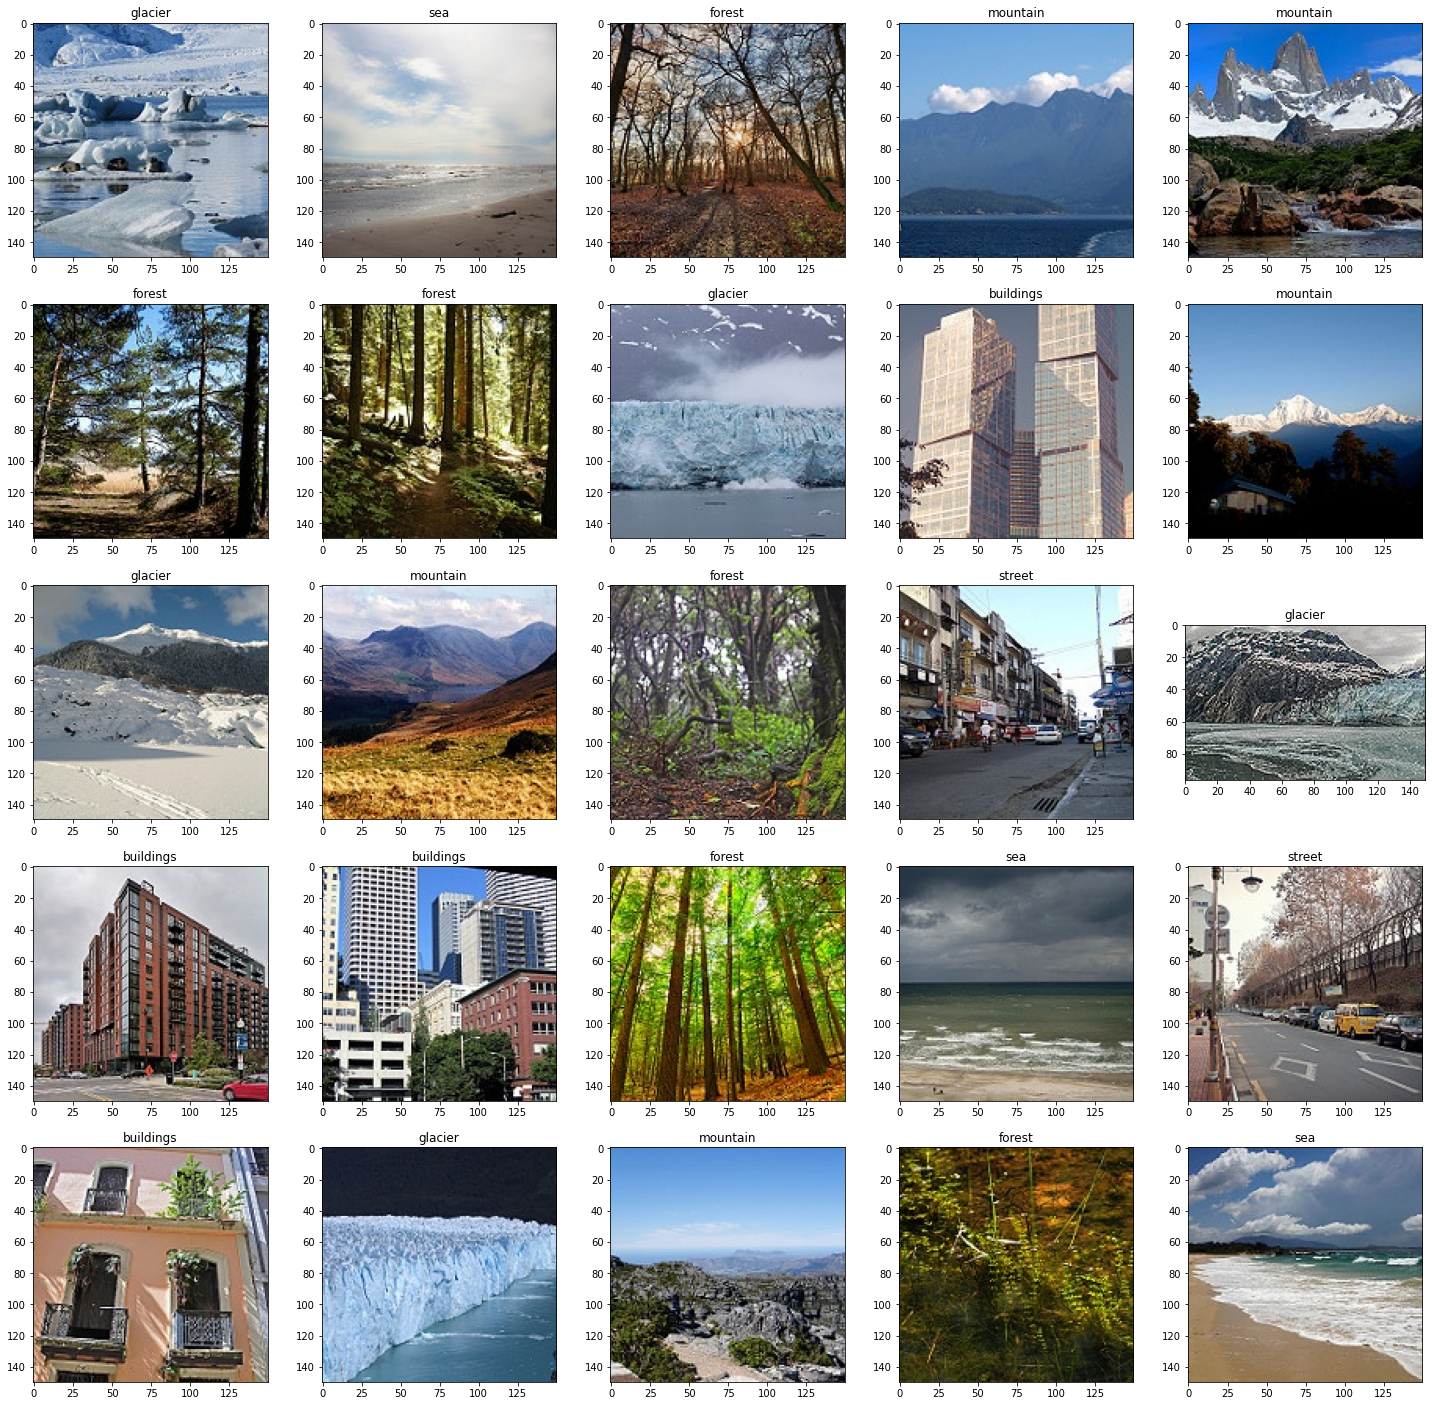

In [3]:
# Plot some random train images
count = 0
fig=plt.figure(figsize=(25,25))

row = 5
column = 5 
count_stop = row * column

for train_image_path in train_images_path:
    img = cv2.imread(train_image_path)
    label = os.path.basename(os.path.dirname(train_image_path))
    count += 1
    
    sub = fig.add_subplot(row, column, count)
    
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(label)
    if count == count_stop:
        break

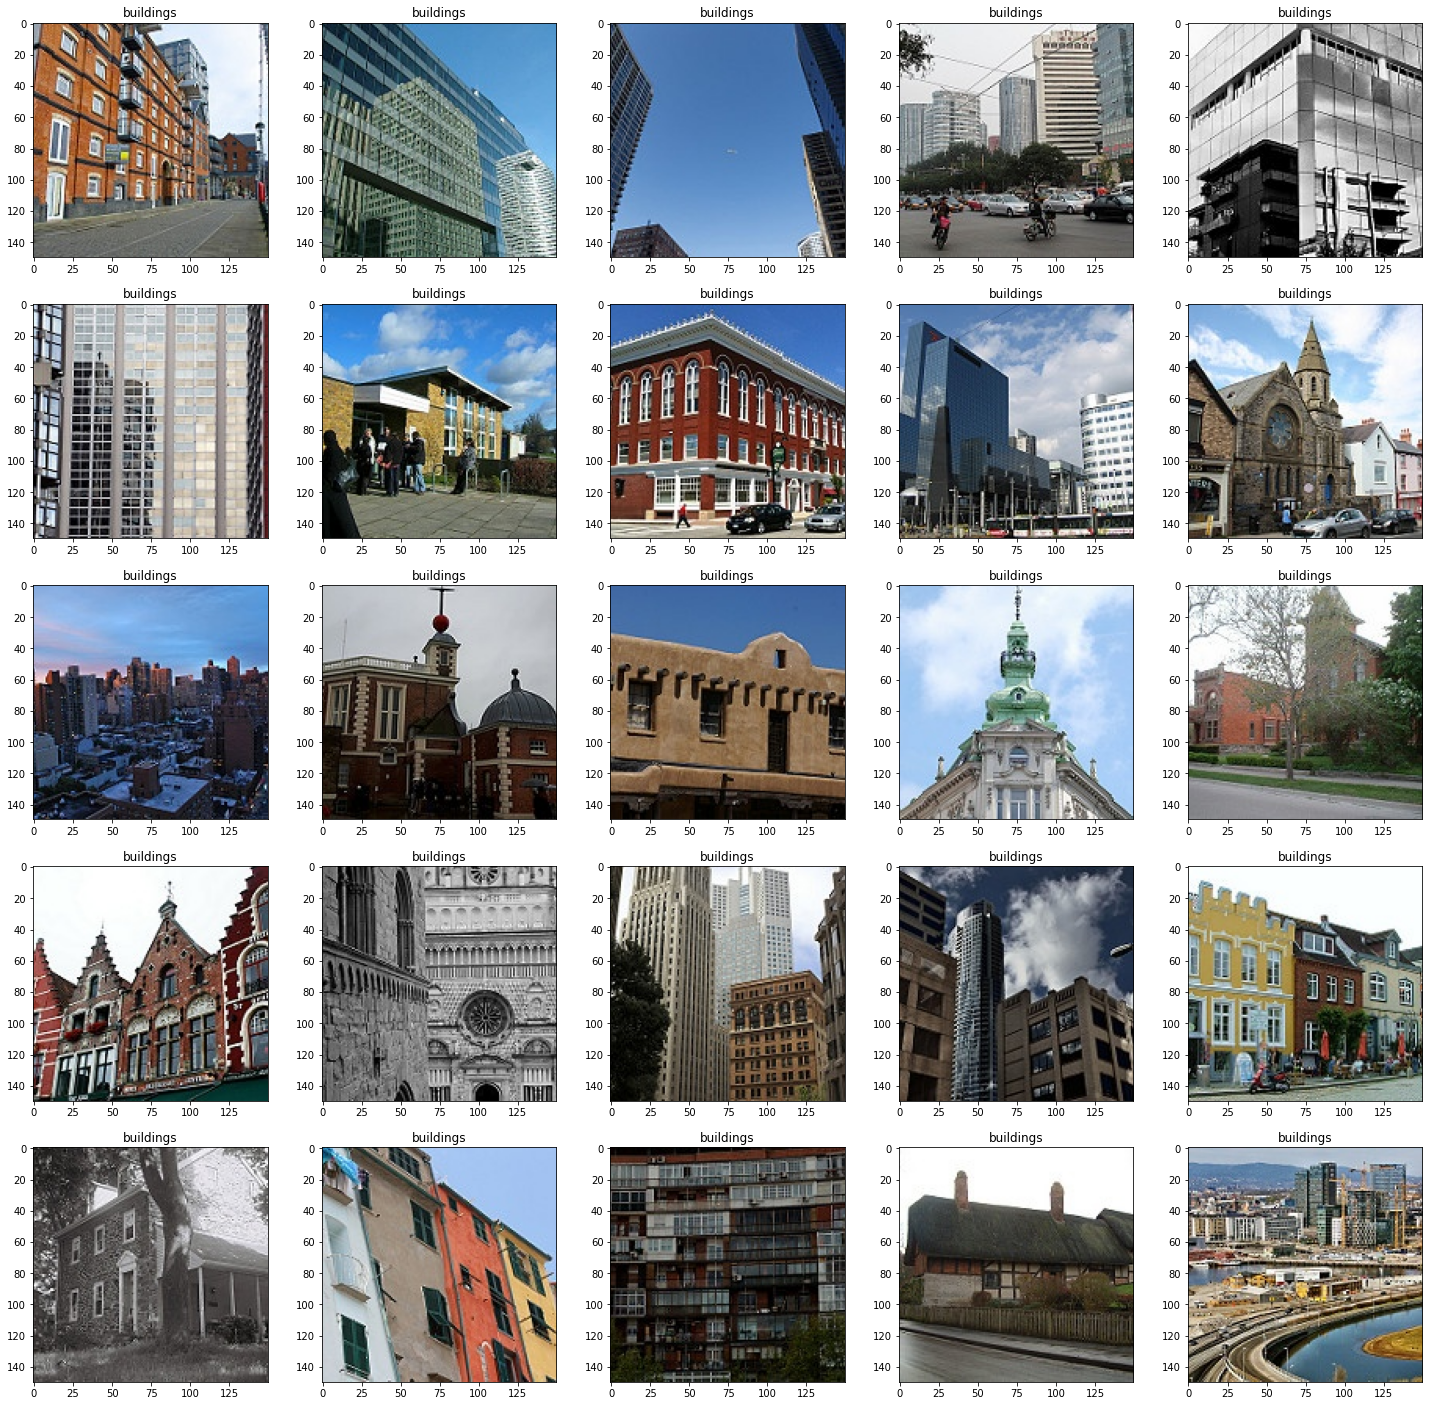

In [4]:
# Plot test data
count = 0
fig=plt.figure(figsize=(25,25))

row = 5
column = 5 
count_stop = row * column

for test_image_path in test_images_path:
    img = cv2.imread(test_image_path)
    label = os.path.basename(os.path.dirname(test_image_path))
    count += 1
    sub = fig.add_subplot(row, column, count)
    
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(label)
    if count == count_stop:
        break

In [5]:
# Plot distribution
train_distribution = {}
for label in labels:
    train_distribution[label] = 0

for train_image_path in train_images_path:
    selected_label = os.path.basename(os.path.dirname(train_image_path))
    
    if selected_label in train_distribution:
        train_distribution[selected_label] += 1

train_distribution

{'buildings': 2191,
 'glacier': 2404,
 'street': 2382,
 'forest': 2271,
 'mountain': 2512,
 'sea': 2274}

In [6]:
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        plt.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

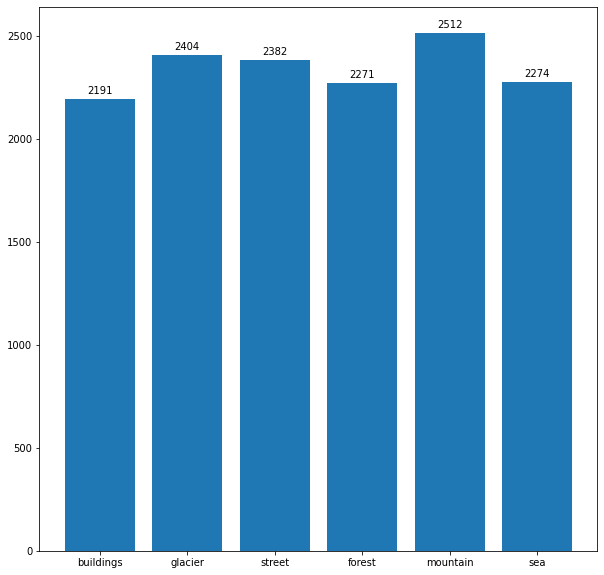

In [7]:
# From the looks of it pretty even distributionb
plt.figure(figsize=(10, 10))
bars = plt.bar(list(train_distribution.keys()), list(train_distribution.values()))
autolabel(bars)

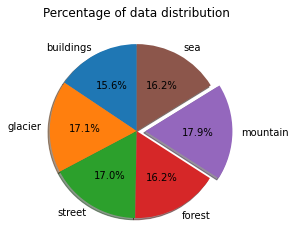

In [8]:
max_explode = max(train_distribution, key=lambda x: train_distribution[x])
explode = [0.1 if key == max_explode else 0.0 for key in list(train_distribution.keys())]
plt.pie(
    list(train_distribution.values()), explode=explode, labels=list(train_distribution.keys()),
    autopct='%1.1f%%',
    shadow=True, startangle=90
)

plt.title('Percentage of data distribution')
plt.show()

# Feature Extraction via PCA
- Using VGG16 to extract features

In [9]:
import tensorflow as tf
import efficientnet.tfkeras as enet

In [10]:
from sklearn import decomposition
from sklearn import manifold

In [23]:
# model = tf.keras.applications.ResNet152V2(weights='imagenet', include_top=False)
model = enet.EfficientNetB5(include_top=False, weights='imagenet')

In [13]:
class_names = ['mountain', 'street', 'glacier', 'buildings', 'sea', 'forest']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

images = []
labels = []

for train_image in  train_images_path[:500]:
    img = cv2.imread(train_image)
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (150, 150))
    images.append(img)
    
    label = os.path.basename(os.path.dirname(train_image))
    labels.append(class_names_label[label])

images = np.array(images, dtype=np.float32)
labels = np.array(labels, dtype=np.int32)

In [24]:
train_features = model.predict(images)

In [25]:
n_train, x, y, z = train_features.shape

In [26]:
numFeatures = x * y * z

In [27]:
pca = decomposition.PCA(n_components = 2)

X = train_features.reshape((n_train, x*y*z))
pca.fit(X)

C = pca.transform(X)
C1 = C[:, 0]
C2 = C[:, 1]

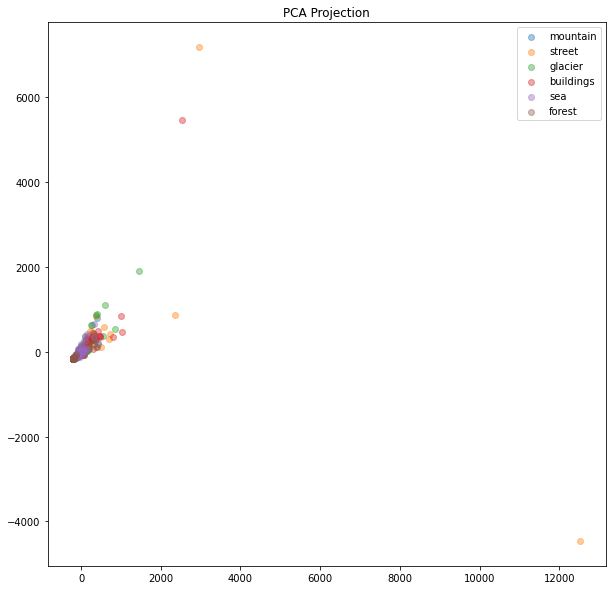

In [28]:
plt.subplots(figsize=(10,10))

for i, class_name in enumerate(class_names):
    plt.scatter(C1[labels == i][:1000], C2[labels == i][:1000], label = class_name, alpha=0.4)
    
plt.legend()
plt.title("PCA Projection")
plt.show()

In [29]:
tsne = manifold.TSNE(n_components=2, random_state=0)

In [30]:
tsne_data = tsne.fit_transform(X)

In [31]:
tsne_data
t1 = tsne_data[:, 0]
t2 = tsne_data[:, 1]

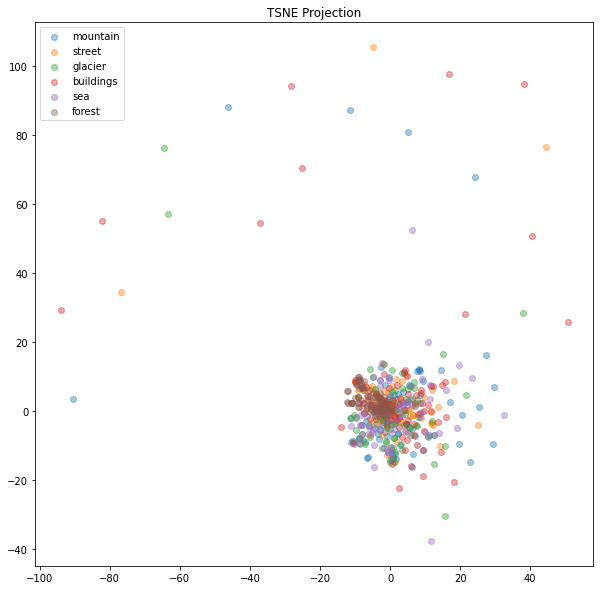

In [32]:
plt.subplots(figsize=(10,10))

for i, class_name in enumerate(class_names):
    plt.scatter(t1[labels == i][:1000], t2[labels == i][:1000], label = class_name, alpha=0.4)
    
plt.legend()
plt.title("TSNE Projection")
plt.show()